In [1]:
import os
import copy as cp
import sys
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
import seaborn
import pickle

from matplotlib.patches import Rectangle

In [2]:
# my code
sys.path.insert(1, '../code/')

from format_helper_functions import find_mutation, make_aa_dict
from rank_functions import compute_mean_ranks
from plot_functions import compute_meta_p, compute_auc, compute_enrichment_accuracy, log_bins
from plot_functions import make_fpr_figure_individual, make_fpr_figure_contacts_asym, compute_enrichment
from plot_functions import plot_enrichment_fos_svg, plot_enrichment_fos, multiple_test_correct, compute_avg_sign_matrix
from mochi_functions import find_mochi_alpha_empirical

In [3]:
# plotting settings
plt.rcParams.update({'font.size': 8})
plt.rcParams["font.family"] = 'Arial'
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Arial"] + plt.rcParams["font.serif"]

In [4]:
input_wt  = np.array ([47550, 62496, 53287])
output_wt = np.array( [162233, 193273, 171470])
y_wt = output_wt / input_wt

In [5]:
# amino acids
aadict = make_aa_dict (stop='*')
aalist = [key for key in aadict.keys ()]

In [6]:
# my files
protein = 'fos'
ligand = 'jun'
indir = '../results/fosjun/325/fos'

# mochi files
mochi_dir = '../results/fosjun/325/fos/mochi_fosjun/'
file_root = 'mochi_sigmoid_'

# number of AAs
nAA = 21

# enrichment p-value
alpha_geom = 0.05

# distance matrix
Dist = np.loadtxt ('../data/fosjun/fosjun_distance_matrix.txt')
Df   = Dist[:32,32:]

# make output directory
outdir = os.path.join (indir, 'plots')
if not os.path.isdir (outdir) :
    os.makedirs (outdir)
    
# whether to save the plots
save = True

In [7]:
# my data files
in_obs_doubles = os.path.join (indir, 'fos_Y_doubles.pkl')
in_obs_singles = os.path.join (indir, 'fos_Y_singles.txt')
in_obs_ligand  = os.path.join (indir, 'jun' + '_Y_singles.txt')
in_obs_reads   = os.path.join (indir, 'fos_D_neutral.pkl')
in_obs_sel_reads   = os.path.join (indir, 'fos_D_selection.pkl')

# read in data
ydoub  = pickle.load ( open (in_obs_doubles, 'rb'))
y_sing = np.loadtxt (in_obs_singles) 
l_sing = np.loadtxt (in_obs_ligand)
N0doub = pickle.load ( open (in_obs_reads, 'rb'))
N1doub = pickle.load ( open (in_obs_sel_reads, 'rb'))
n0_sing  = np.loadtxt (os.path.join (indir, protein + '_S_neutral.txt'))
n0_lsing = np.loadtxt (os.path.join (indir, ligand + '_S_neutral.txt'))

In [8]:
Llig, L, nreps = ydoub.shape
npos = int (L / nAA)

print (npos)

32


In [9]:
# make big distance matrix
bigDist = np.zeros ((Llig,L))
for i in range (npos) :
    bigDist[(i*nAA):(i*nAA + nAA),:] = np.reshape (np.repeat (Df[i,:], nAA**2), (nAA, L), order='F')

In [10]:
# p-values
Pvals  = np.zeros_like (ydoub)
Ptwo   = np.zeros_like (Pvals)
Dmats  = np.zeros_like (ydoub)
Lmats  = np.zeros ( (L, Llig, nreps))
Dsyms  = np.zeros_like (Dmats)
Rmats  = np.zeros_like (Dmats)
LRmats = np.zeros_like (Dmats)
for i in range (nreps) :
    Pvals[:,:,i] = np.loadtxt (os.path.join (indir, 'rep_' + str (i), protein + '_Psymmetric.txt'))
    Ptwo[:,:,i]  = 2 * np.loadtxt (os.path.join (indir, 'rep_' + str (i), protein + '_Ptwosided.txt'))

    Dmats[:,:,i] = np.loadtxt (os.path.join (indir, 'rep_' + str (i), protein + '_Dmat.txt'))
    Lmats[:,:,i] = np.loadtxt (os.path.join (indir, 'rep_' + str (i), protein + '_LDmat.txt'))
    Dsyms[:,:,i] = Dmats[:,:,i] + np.transpose (Lmats[:,:,i])
    
    Rmats[:,:,i]  = np.loadtxt (os.path.join (indir, 'rep_' + str (i), protein + '_Rmat.txt'))
    LRmats[:,:,i] = np.loadtxt (os.path.join (indir, 'rep_' + str (i), protein + '_Lmat.txt'))

In [11]:
# set max P value for two-sided to 1
Ptwo[Ptwo > 1] = 1.

# -1s to NAs
n0_doub = np.array (N0doub, dtype=float)
n0_doub[N0doub == -1] = np.nan

In [12]:
print (np.nanmean (n0_sing))
print (np.nanmean (n0_lsing))
print (np.nanmean (N0doub))

tots = np.zeros ( (4, nreps) )
for i in range (nreps) :
    tots[0,i] = np.sum (~np.isnan (Pvals[:,:,i]))
    tots[1,i] = np.sum (~np.isnan (y_sing[:,i]))
    tots[2,i] = np.sum (~np.isnan (l_sing[:,i]))    
    tots[3,i] = np.sum (~np.isnan (Pvals[:,:,i])) / (npos**2 * 20**2)
    
print (np.nanmean (tots, axis=1))

print (np.nanmean (n0_doub))
print (np.nanmean (n0_sing))
print (np.nanmean (n0_lsing))

1021.96875
931.0560515873016
21.91811047335601
[1.74872667e+05 6.39666667e+02 6.40000000e+02 4.26935221e-01]
58.18143453481501
1021.96875
931.0560515873016


In [13]:
# data
data = pandas.read_csv (os.path.join (mochi_dir, file_root + '0.txt'), delimiter='\t', low_memory=False)

# wildtype sequence
all_wt = data['aa_seq'][data['WT'] == True].to_list ()[0]

In [14]:
# organize data from Mochi
Yd   = np.zeros ( (Llig, L, nreps+1) ) * np.nan
Ystd = np.zeros_like (Yd) * np.nan
Yest = np.zeros_like (Yd) * np.nan
Lam_d = np.zeros_like (Yd) * np.nan

Ys = np.zeros ( (L, nreps+1) ) * np.nan
Ys_est = np.zeros_like (Ys) * np.nan
Lam_s = np.zeros_like (Ys) * np.nan
Yl = np.zeros ( (Llig, nreps+1) ) * np.nan
Ys_std = np.zeros_like (Ys) * np.nan
Yl_std = np.zeros_like (Yl) * np.nan
Lam_l = np.zeros_like (Yl) * np.nan

for i in range (nreps+1) :
    count = 0
    if i < nreps :
        data_me = pandas.read_csv (os.path.join (mochi_dir, file_root + str (i) + '.txt'),
                               delimiter='\t', low_memory=False)
    else :
        data_me = pandas.read_csv (os.path.join ( mochi_dir, 'mochi_sigmoid_all.txt'),
                                   delimiter='\t', low_memory=False)
    
    for index, row in data_me.iterrows () :

        muts = find_mutation (row['aa_seq'], all_wt)

        if len (muts) == 2 :
            if row['Nham_aa'] != 2 :
                print ('Wrong number of mutations.')
                print (index)

            pp_i, pm_i = muts[0]
            cp_i, cm_i = muts[1]

            cp_i -= npos

            Yd[pp_i*nAA + aadict[pm_i], cp_i*nAA + aadict[cm_i], i]   = row['fitness']
            Ystd[pp_i*nAA + aadict[pm_i], cp_i*nAA + aadict[cm_i], i] = row['sigma']
            Yest[pp_i*nAA + aadict[pm_i], cp_i*nAA + aadict[cm_i], i] = row['mean']
            Lam_d[pp_i*nAA + aadict[pm_i], cp_i*nAA + aadict[cm_i], i] = row['fold_10_additive_trait0']

        if len (muts) == 1 :
            if row['Nham_aa'] != 1 :
                print ('Wrong number of mutations.')
                print (index)
                
            pp_i, pm_i = muts[0]  

            if pp_i > (npos-1) :
                pp_i -= npos
                Yl[pp_i*nAA + aadict[pm_i], i] = row['fitness']
                Yl_std[pp_i*nAA + aadict[pm_i], i] = row['sigma']
                Lam_l[pp_i*nAA + aadict[pm_i], i] = row['fold_10_additive_trait0']

            else :
                Ys[pp_i*nAA  + aadict[pm_i], i] = row['fitness']
                Ys_std[pp_i*nAA + aadict[pm_i], i] = row['sigma']
                Ys_est[pp_i*nAA + aadict[pm_i], i] = row['mean']
                Lam_s[pp_i*nAA + aadict[pm_i], i] = row['fold_10_additive_trait0']

In [15]:
# Compute R2
for i in range (nreps+1) :
    SSres = (Yd[:,:,i] - Yest[:,:,i])**2
    SStot = (Yd[:,:,i] - np.nanmean (Yd[:,:,i]))**2
    R2    = 1. - np.nansum (SSres)/ np.nansum (SStot)
    print ('Prediction accuracy: ' + str (R2))

# Compute residuals
#pdz3cript_dm$zscore_dm <- (pdz3cript_dm$`pdz3cript_resids[pdz3cript_double_mut_pos]`)/sqrt((pdz3cript_dm$sigma)^2)
Res = (Yd - Yest) / Ystd

# compute p values
Pmochi    = np.zeros_like (Res)
mochi_fdr = np.zeros (nreps+1)
for i in range (nreps+1) :
    Res_i = (Yd[:,:,i] - Yest[:,:,i]) / Ystd[:,:,i]
    
    # save residuals to file
    np.savetxt (os.path.join (outdir, 'mochi_res_rep_' + str (i) + '.txt'),
                np.transpose (Res_i))
    Pmochi[:,:,i] = 2*scipy.stats.norm.cdf (-abs (Res_i))
    
    pvalues      = cp.deepcopy (Pmochi[:,:,i])
    fdr_ps       = scipy.stats.false_discovery_control ( pvalues[~np.isnan (pvalues)], method='bh' )
    mochi_fdr[i] = np.nanmax (pvalues[~np.isnan (pvalues)][fdr_ps < alpha_geom])
    
Pmochi[Pmochi == 0] = np.nanmin (Pmochi[Pmochi > 0])

Prediction accuracy: 0.8975210891753028
Prediction accuracy: 0.8957789447000932
Prediction accuracy: 0.8945469860099781
Prediction accuracy: 0.9179046823485012


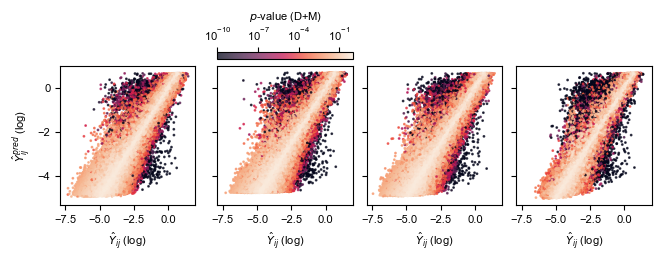

In [16]:
plt.rcParams["figure.figsize"] = (6.5,2.5)

fig, axs = plt.subplots (1, nreps+1, sharex=True, sharey=True, constrained_layout=True)

for i in range (nreps+1) :
    
    Pm_cp = cp.deepcopy (Pmochi[:,:,i])
    Pm_cp[Pm_cp < 1e-10] = 1e-10
    myp = axs[i].scatter (Yd[:,:,i], Yest[:,:,i], s=1, alpha=0.75,
                 cmap='rocket', c=Pm_cp, norm=mpl.colors.LogNorm (vmin=1e-10, vmax=1))
    axs[i].set_xlabel (r'$\hat Y_{ij}$ (log)')
    
fig.colorbar (myp, ax=axs[1], location='top', label=r'$p$-value (D+M)')
    #plt.colorbar ()
axs[0].set_ylabel (r'$\hat Y_{ij}^{pred}$ (log)')
plt.show ()

In [17]:
# save mochi p-values to file
for i in range (nreps + 1) :
    np.savetxt (os.path.join (outdir, 'mochi_ps_rep_' + str (i) + '.txt'),
                np.transpose (Pmochi[:,:,i]))
    
    if i < nreps :
        print (np.sum (~np.isnan (Pvals[:,:,i])))
        print (np.sum (~np.isnan (Pmochi[:,:,i])))        

168242
168242
183523
183523
172853
172865


In [18]:
# meta p-value efor mochi
metaMochi = compute_meta_p (Pmochi[:,:,:nreps], omit=True, nthres=2)
metaP     = compute_meta_p (Pvals, omit=True, nthres=2)
metaPtwo  = compute_meta_p (Ptwo, omit=True, nthres=2)

In [19]:
# compute accuracy and recall for each replicate and the meta p-values
nalphas = 1000
alphas  = np.linspace (1/nalphas, 1, nalphas)
dists   = [3, 5]

# for mochi
Acc_reps  = np.zeros ((nreps+1, nalphas, len (dists)))
Prop_reps = np.zeros_like (Acc_reps)
# for R&R
Acc_reps_r  = np.zeros ((nreps+1, nalphas, len (dists)))
Prop_reps_r = np.zeros_like (Acc_reps)
for d in range (len (dists)) :
    d_i = dists[d]
    for i in range (nreps+1) :
        Acc_reps[i,:,d], Prop_reps[i,:,d] = compute_auc ( Pmochi[:,:,i], Dist=bigDist,
                                                      distance_thres=d_i, quantile=True, alphas=alphas)
    
    for i in range (nreps) :
        Acc_reps_r[i,:,d], Prop_reps_r[i,:,d] = compute_auc ( np.transpose (Pvals[:,:,i]), Dist=bigDist,
                                                              distance_thres=d_i, quantile=True, alphas=alphas)

    # for R&R meta p-values
    Acc_reps_r[-1,:,d], Prop_reps_r[-1,:,d] = compute_auc ( np.transpose (metaP), Dist=bigDist,
                                                           distance_thres=d_i, quantile=True, alphas=alphas)

9.261816609130294e-25
1.8193319042245274e-27
3.967471815582071e-26
1.45767653382287e-54
0.001998001998001998
0.002997002997002997
0.001998001998001998
1.2036756867339626e-05
9.261816609130294e-25
1.8193319042245274e-27
3.967471815582071e-26
1.45767653382287e-54
0.001998001998001998
0.002997002997002997
0.001998001998001998
1.2036756867339626e-05


In [20]:
plt.rcParams["figure.figsize"] = (6.5,1.75)

fig, axs = plt.subplots (1, nreps+1, sharex=True, sharey=True, constrained_layout=True)

min_x = np.min ([np.nanmin (Prop_reps), np.nanmin (Acc_reps)])
for i in range (nreps+1) :
    if i == nreps :
        axs[i].set_title ('Combined')        
    else :
        axs[i].set_title ('Rep ' + str (i+1)) 

    for d in range (len (dists)) :
        
        # plot both mochi and R&R
        axs[i].plot (Prop_reps[i,:,d], Acc_reps[i,:,d],
                     linestyle=['solid', 'dotted'][d], color='dodgerblue', linewidth=1.,
                     label='D+M ' + ['3','5'][d])
        axs[i].plot (Prop_reps_r[i,:,d], Acc_reps_r[i,:,d], linestyle=['solid', 'dotted'][d],
                     color='orange', linewidth=1.,
                     label='R&R ' + ['3','5'][d])
    
    # identity line
    axs[i].plot ( np.linspace (min_x, 1, 20), np.linspace (min_x, 1, 20),
                 linestyle='solid', color='black', linewidth=.25, label='id')
    
    axs[i].set_xlabel ('pseudo-false pos. rate')
    axs[i].set_xscale ('log')
    axs[i].set_yscale ('log')

axs[-1].legend (bbox_to_anchor=(1.05,1.))
axs[0].set_ylabel ('pseudo-true pos. rate')

if save :
    plt.savefig (os.path.join (outdir, 'auc_curves.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [21]:
# compute accuracy and recall for each replicate and the meta p-values
nalphas = 50
alphas  = np.linspace (1/nalphas, 1, nalphas)
alphas_r = np.logspace (-2,np.log10 (.5), nalphas)
alphas_m = np.logspace (-50,np.log10 (.5), nalphas)

# for mochi
Acc_reps  = np.zeros ((nreps+1, nalphas))
Prop_reps = np.zeros_like (Acc_reps)
for i in range (nreps+1) :
    print (i)
    Acc_reps[i,:], Prop_reps[i,:] = compute_enrichment_accuracy ( Pmochi[:,:,i], Dist=Df,
                                                                  distance_thres=5, quantile=False,
                                                                  alphas=alphas_m)
    
# for R&R
Acc_reps_r  = np.zeros ((nreps+1, nalphas))
Prop_reps_r = np.zeros_like (Acc_reps)
for i in range (nreps) :
    Acc_reps_r[i,:], Prop_reps_r[i,:] = compute_enrichment_accuracy ( np.transpose (Pvals[:,:,i]), Dist=Df,
                                                                      distance_thres=5, quantile=False,
                                                                      alphas=alphas_r)
    
# for R&R meta p-values
Acc_reps_r[nreps,:], Prop_reps_r[nreps,:] = compute_enrichment_accuracy ( np.transpose (metaP), Dist=Df,
                                                                   distance_thres=5, quantile=False,
                                                                   alphas=alphas_r)

0
1
2
3


In [22]:
# find the best alpha values in terms of accuracy and recall
best_alphas_mochi = np.zeros (nreps+1)
best_alphas_randr = np.zeros (nreps+1)
for i in range (nreps+1) :
    best_alphas_mochi[i] = alphas_m[np.nanargmax (Prop_reps[i,:] + Acc_reps[i,:])]
    best_alphas_randr[i] = alphas_r[np.nanargmax (Prop_reps_r[i,:] + Acc_reps_r[i,:])]

print (best_alphas_mochi)
print (best_alphas_randr)

[2.76825130e-19 2.34899473e-24 2.50848455e-22 1.14040412e-46]
[0.01748679 0.03312019 0.10127747 0.11881153]


In [23]:
plt.rcParams["figure.figsize"] = (6,2.25)

fig, axs = plt.subplots (1, nreps+1, sharex=True, sharey=True, constrained_layout=True)

for i in range (nreps+1) :
    
    # plot both mochi and R&R
    myp_d = axs[i].scatter (Prop_reps[i,:] + np.random.normal (0, .02, nalphas), Acc_reps[i,:], cmap='Blues_r',
                            norm=mpl.colors.LogNorm (), marker='v',
                            s=10, c=alphas_m, edgecolor='navy', linewidth=.1, label='D+M')
    myp_r = axs[i].scatter (Prop_reps_r[i,:] + np.random.normal (0, .02, nalphas), Acc_reps_r[i,:] ,
                            norm=mpl.colors.LogNorm (), edgecolor='red',
                          cmap='rocket', s=10, c=alphas_r, linewidth=.1, label='R&R')
    
    if i < nreps :
        axs[i].set_title ('rep ' + str (i+1) )
    else :
        axs[i].set_title ('combined')
        
    axs[i].set_xlabel ('pseudo-recall')
    axs[i].set_ylim ( (-0.05, 1.1) )
    #axs[i].set_xscale ('log')

fig.colorbar (myp_d, ax=axs[2], location='top', label=r'D+M $\alpha$' )
fig.colorbar (myp_r, ax=axs[1], location='top', label=r'R&R $\alpha$' )

axs[0].set_ylabel ('pseudo-accuracy')

if save :
    plt.savefig (os.path.join (outdir, 'accuracy_recall_enrichment.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [24]:
# p-value histograms
plt.rcParams["figure.figsize"] = (2,2)

fig, axs = plt.subplots (4, 1, sharex=True, sharey=True)

for i in range (nreps+1) :
    if i <= 2 :
        Pfoc = cp.deepcopy (Pvals[:,:,i])
        label = 'rep ' + str (i+1)
    else :
        Pfoc = cp.deepcopy (metaP)
        label = 'meta'
        
    axs[i].hist (np.ndarray.flatten (Pfoc), bins=20,
                 color='lightgray', edgecolor='black', linewidth=.01)
    
    axs[i].annotate ( label, (.01,12000), fontsize=7)
    if i == 1 :
        axs[i].set_ylabel ('Count', labelpad=1)

axs[-1].set_xticks (np.linspace (0,1,5), np.linspace (0,1,5))
axs[-1].set_xlabel (r'$p$-value', labelpad=.5)

if save :
    plt.savefig (os.path.join (outdir, 'pij_values.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [25]:
# p-value histograms
plt.rcParams["figure.figsize"] = (2,2)

fig, axs = plt.subplots (4, 1, sharex=True, sharey=True)

for i in range (nreps+1) :
    if i <= 2 :
        Pfoc = cp.deepcopy (Pmochi[:,:,i])
        label = 'rep ' + str (i+1)
    else :
        Pfoc = cp.deepcopy (metaMochi)
        label = 'meta'
        
    axs[i].hist (np.ndarray.flatten (Pfoc), bins=20,
                 color='lightgray', edgecolor='black', linewidth=.01)
    
    axs[i].annotate ( label, (.85,20000), fontsize=7)
    if i == 1 :
        axs[i].set_ylabel ('Count', labelpad=1)

axs[-1].set_xticks (np.linspace (0,1,5), np.linspace (0,1,5))
axs[-1].set_xlabel (r'$p$-value', labelpad=.5)

if save :
    plt.savefig (os.path.join (outdir, 'pij_values_mochi.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [26]:
plt.rcParams["figure.figsize"] = (4.75,1.5)

fig, axs = plt.subplots (1,3, sharex=True, sharey=True, constrained_layout=True)

ct = 0
for i in range (nreps) :
    for j in range (i+1, nreps) :
        axs[ct].hist2d (np.ndarray.flatten (Pvals[:,:,i]),
                              np.ndarray.flatten (Pvals[:,:,j]),
                              bins=np.logspace (np.log10 (np.nanmin (Pvals)), 0, 15),
                              norm=mpl.colors.LogNorm (vmin=1, vmax=47000), cmap='gray_r')

        axs[ct].set_xlabel (r'Rep. ' + str (i+1))
        axs[ct].set_ylabel (r'Rep. ' + str (j+1))
        axs[ct].set_xscale ('log')
        axs[ct].set_yscale ('log')
        
        val_i = cp.deepcopy (np.ndarray.flatten (Pvals[:,:,i]))
        val_j = cp.deepcopy (np.ndarray.flatten (Pvals[:,:,j]))
        
        print (scipy.stats.pearsonr (val_i[np.logical_and (~np.isnan (val_i), ~np.isnan (val_j))],
                                     val_j[np.logical_and (~np.isnan (val_i), ~np.isnan (val_j))] ))
        print (scipy.stats.spearmanr (np.ndarray.flatten (Pvals[:,:,i]), np.ndarray.flatten (Pvals[:,:,j]),
                                      nan_policy='omit') )
        print (scipy.stats.spearmanr (np.ndarray.flatten (Dsyms[:,:,i]), np.ndarray.flatten (Dsyms[:,:,j]),
                                      nan_policy='omit') )
        
        print ( np.sum (np.logical_and (Pvals[:,:,i] < alpha_geom, Pvals[:,:,j] < alpha_geom) ) /
                np.sum (Pvals[:,:,i] < alpha_geom))
        print ( np.sum (np.logical_and (Pvals[:,:,i] < alpha_geom, Pvals[:,:,j] < alpha_geom) ) /
                np.sum (Pvals[:,:,j] < alpha_geom))
        ct += 1
        
cmap = mpl.cm.gray_r
norm = mpl.colors.LogNorm (vmin=1, vmax=47000)
fig.colorbar (mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
              ax=axs[-1], label='# $p$-values')
if save :
    plt.savefig (os.path.join (outdir, 'fos_pvalue_reps.pdf'), bbox_inches='tight', dpi=600,
                transparent=True)
    plt.close ()
else :
    plt.show ()

PearsonRResult(statistic=0.20483591341342974, pvalue=0.0)
SignificanceResult(statistic=0.19576026449549175, pvalue=0.0)
SignificanceResult(statistic=0.4137138420746015, pvalue=0.0)
0.27435328898743533
0.24337791765014424
PearsonRResult(statistic=0.21448266456595605, pvalue=0.0)
SignificanceResult(statistic=0.20559291031181148, pvalue=0.0)
SignificanceResult(statistic=0.42077920777964195, pvalue=0.0)
0.27627494456762747
0.26088777219430487
PearsonRResult(statistic=0.2108689073795068, pvalue=0.0)
SignificanceResult(statistic=0.2019383497396112, pvalue=0.0)
SignificanceResult(statistic=0.4220441330064416, pvalue=0.0)
0.25714660372410175
0.27372975991066445


In [27]:
plt.rcParams["figure.figsize"] = (3.5,2.5)

logbins = log_bins (ydoub, 20)

fig, axs = plt.subplots (3,3, sharex=True, sharey='row', constrained_layout=True)

ct = 0
for i in range (nreps) :
    for j in range (i+1, nreps) :
        
        vals = np.nanmean (ydoub[np.logical_and (Pvals[:,:,i] <= alpha_geom, Pvals[:,:,j] > alpha_geom),:], axis=1)
        vals = np.append (vals, np.nanmean (ydoub[np.logical_and (Pvals[:,:,j] <= alpha_geom, Pvals[:,:,i] > alpha_geom)], axis=1))
        
        print (np.sum (~np.isnan (vals)))
        axs[0,ct].hist (vals, bins=logbins, color='lightgray', edgecolor='black', linewidth=0.1)
        
        vals = np.nanmean (ydoub[np.logical_and (Pvals[:,:,i] <= alpha_geom, Pvals[:,:,j] <= alpha_geom)], axis=1)        
        print (np.sum (~np.isnan (vals)))
        axs[1,ct].hist (np.ndarray.flatten (vals), bins=logbins,
                        color='gray', edgecolor='black', linewidth=0.1)
        
        
        axs[2,ct].hist ( np.ndarray.flatten ((ydoub[:,:,i] + ydoub[:,:,j]) /2), bins=logbins,
                        color='moccasin', edgecolor='black', linewidth=0.1 )
                
        axs[0,ct].set_xscale ('log')
        axs[2,ct].set_xlabel (r'$\bar Y_{ij}$', labelpad=0)
        for k in range (2) :
            axs[k,ct].tick_params (length=2, pad=1)
        axs[0,ct].set_title ('Rep ' + str (i) + ' vs. ' + str (j))

        ct += 1

for k in range (3) :
    axs[k,0].set_ylabel ('Count')
    axs[k,-1].yaxis.set_label_position("right")

axs[0,-1].set_ylabel ('Not shared', rotation=270, labelpad=10)
axs[1,-1].set_ylabel ('Shared', rotation=270, labelpad=10)
axs[2,-1].set_ylabel ('All', rotation=270, labelpad=10)


if save :
    plt.savefig (os.path.join (outdir, 'y_val_replicate.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

8687
1856
8456
1869
9000
1961


In [28]:
# find correct mochi significance threshold
mochi_thresholds = np.zeros (nreps)
two_thresholds   = np.zeros (nreps)
for i in range (nreps) :
    
    
    mochi_thresholds[i] = find_mochi_alpha_empirical (np.transpose (Pvals[:,:,i]), Pmochi[:,:,i],
                                                      bigDist, alpha_geom, alphas=np.logspace (-5,-1,1000),
                                                      dthres=5)
    
        
    two_thresholds[i] = find_mochi_alpha_empirical (np.transpose (Pvals[:,:,i]), np.transpose (Ptwo[:,:,i]),
                                                      bigDist, alpha_geom, alphas=np.logspace (-5,-1,1000),
                                                      dthres=5)


    make_fpr_figure_individual (np.transpose (Pvals[:,:,i]), bigDist,
                                np.transpose (Dsyms[:,:,i]),
                                ls=y_sing[:,i], ys=l_sing[:,i], alpha=alpha_geom,
                                outlabel=protein + '_' + str (i), save=save,
                                outdir=outdir, figsize=(.9,.9),
                                conmax=None, fpmax=None, powermax=None)
    
    make_fpr_figure_individual (Pmochi[:,:,i], bigDist, Res[:,:,i],
                                ls=y_sing[:,i], ys=l_sing[:,i], alpha=mochi_thresholds[i],
                                outlabel=protein + '_mochi_' + str (i), save=save,
                                outdir=outdir, figsize=(1.2,1.2),
                                conmax=None, fpmax=None, powermax=None)

(672, 672)
283342
283342
283342
None
0.20199778024417314
power:
0.4444444444444444


/Users/maryncarlson/nitmb/resample_and_reorder/notebooks/../code/plot_functions.py:374: RuntimeWarning: invalid value encountered in scalar divide
  Power[i,j] = num_ij / den_ij


0.061877667140825036
(672, 672)
283342
283342
283342
None
0.20199778024417314
power:
0.6666666666666666
0.13264604810996564
(672, 672)
268061
268061
268061
None
0.2112088930060213
power:
0.5
0.06141439205955335
(672, 672)
268061
268061
268061
None
0.2112088930060213
power:
0.5
0.12234042553191489
(672, 672)
278731
278731
278731
None
0.20342612419700215
power:
0.8
0.06471389645776567
(672, 672)
278719
278719
278719
None
0.20342612419700215
power:
0.8
0.1231630510846746


In [29]:
print (mochi_thresholds)
print (two_thresholds)

[0.00361875 0.00238989 0.00300939]
[0.04827071 0.04827071 0.04827071]


In [30]:
for i in range (nreps+1) :    
    
    if i < nreps :   
        # mochi figure
        make_fpr_figure_contacts_asym ( P=Pmochi[:,:,i], Imat=bigDist, Dmat=Res[:,:,i],
                                        ys=l_sing[:,i], ls=y_sing[:,i], svg=False,
                                        alpha=mochi_thresholds[i], 
                                        outlabel=protein + '_mochi_' + str (i),
                                        save=save, outdir=outdir)
        
    else :
        # mochi threshold
        mochi_alpha_thres = find_mochi_alpha_empirical ( pval_r=np.transpose (metaP),
                                                         pval_m=Pmochi[:,:,-1],
                                                         imat=bigDist,
                                                         alpha_sig=alpha_geom,
                                                         alphas=np.logspace(-50,-2,1000), dthres=5)
        
        # make figure
        make_fpr_figure_contacts_asym (P=Pmochi[:,:,i], Imat=bigDist, Dmat=Res[:,:,i],
                                       ys=np.nanmean (np.log10 (l_sing), axis=1),
                                       ls=np.nanmean (np.log10 (y_sing), axis=1), svg=False,
                                       alpha=mochi_alpha_thres, 
                                       outlabel=protein + '_mochi_' + str (i),
                                       save=save, outdir=outdir)


max fp: 0.13264604810996564
max fp: 0.12234042553191489
max fp: 0.1231630510846746


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/3779556221.py:21: RuntimeWarning: Mean of empty slice
  ys=np.nanmean (np.log10 (l_sing), axis=1),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/3779556221.py:22: RuntimeWarning: Mean of empty slice
  ls=np.nanmean (np.log10 (y_sing), axis=1), svg=False,


max fp: 0.14780457637600494


In [31]:
for i in range (nreps) :    

    make_fpr_figure_contacts_asym (P=np.transpose (Pvals[:,:,i]),
                                   Imat=bigDist,
                                   Dmat=np.transpose (Dsyms[:,:,i]),
                                   ys=l_sing[:,i], ls=y_sing[:,i],
                                   alpha=alpha_geom, svg=False,
                                   outlabel=protein + '_' + str (i), save=save,
                                   outdir=outdir)

    make_fpr_figure_contacts_asym (P=np.transpose (Ptwo[:,:,i]),
                                   Imat=bigDist,
                                   Dmat=np.transpose (Dsyms[:,:,i]),
                                   ys=l_sing[:,i], ls=y_sing[:,i],
                                   alpha=two_thresholds[i], 
                                   outlabel=protein + '_two_' + str (i),
                                   save=save, outdir=outdir)

max fp: 0.061877667140825036
max fp: 0.06156156156156156
max fp: 0.06141439205955335
max fp: 0.05886426592797784
max fp: 0.06471389645776567
max fp: 0.058784676354029064


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/2559774262.py:12: RuntimeWarning: Mean of empty slice
  plot_enrichment_fos (Epos_mochi, np.nanmean (Res, axis=2), Df, metaMochi,


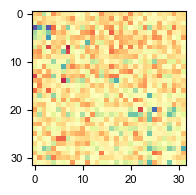

/Users/maryncarlson/nitmb/resample_and_reorder/notebooks/../code/plot_functions.py:147: RuntimeWarning: divide by zero encountered in log10
  s=(-np.log10 (Emat[x,y])))
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/2559774262.py:16: RuntimeWarning: Mean of empty slice
  plot_enrichment_fos (Epos_mochi, np.nanmean (Res, axis=2), Df, metaMochi,


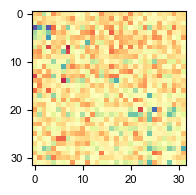

/Users/maryncarlson/nitmb/resample_and_reorder/notebooks/../code/plot_functions.py:147: RuntimeWarning: divide by zero encountered in log10
  s=(-np.log10 (Emat[x,y])))


In [32]:
# meta p-values
#metaMochi = compute_meta_p (Pmochi[:,:,:nreps], omit=True, nthres=2)
metaMochi = cp.deepcopy (Pmochi[:,:,-1])

# remove null alleles
nidxs     = np.arange (nAA-1,L,nAA)
metaMochi_null = cp.deepcopy (metaMochi)
metaMochi_null[nidxs,:] = np.nan
metaMochi_null[:,nidxs] = np.nan

Epos_mochi, Etot_mochi = compute_enrichment (Pmochi[:,:,-1], alpha=best_alphas_mochi[-1])
plot_enrichment_fos (Epos_mochi, np.nanmean (Res, axis=2), Df, metaMochi,
                         outdir=outdir, outlabel='mochi_null_', save=save)

Epos_mochi, Etot_mochi = compute_enrichment (metaMochi_null, alpha=best_alphas_mochi[-1])
plot_enrichment_fos (Epos_mochi, np.nanmean (Res, axis=2), Df, metaMochi,
                         outdir=outdir, outlabel='mochi_nonull_', save=save)

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/827204090.py:2: RuntimeWarning: Mean of empty slice
  plot_enrichment_fos_svg (np.transpose (Epos), np.transpose (np.nanmean (Dsyms, axis=2)),


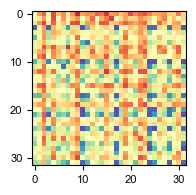

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/827204090.py:14: RuntimeWarning: Mean of empty slice
  plot_enrichment_fos_svg (np.transpose (Epos), np.transpose (np.nanmean (Dsyms, axis=2)),


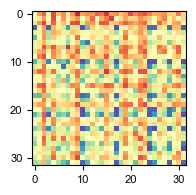

In [33]:
Epos, Etot = compute_enrichment (metaP, alpha=alpha_geom)
plot_enrichment_fos_svg (np.transpose (Epos), np.transpose (np.nanmean (Dsyms, axis=2)),
                         Df, np.transpose (metaP),
                         outdir=outdir, outlabel='randr_null_', save=save,
                         figsize=(2.25,2.25))

# remove null alleles
nidxs     = np.arange (nAA-1,L,nAA)
metaP_null = cp.deepcopy (metaP)
metaP_null[nidxs,:] = np.nan
metaP_null[:,nidxs] = np.nan

Epos, Etot = compute_enrichment (metaP_null, alpha=alpha_geom)
plot_enrichment_fos_svg (np.transpose (Epos), np.transpose (np.nanmean (Dsyms, axis=2)),
                         Df, np.transpose (metaP),
                         outdir=outdir, outlabel='randr_no_null_', save=save,
                         figsize=(2.25,2.25))




In [34]:
Efdr = multiple_test_correct (Epos)
Dcp  = np.nanmean (Dsyms, axis=2)

metacp = cp.deepcopy (metaP)
# remove null alleles
nidxs = np.arange (nAA-1,L,nAA)
metacp[nidxs,:] = np.nan
metacp[:,nidxs] = np.nan
Dcp[metacp > .1] = np.nan

x, y = np.where (np.logical_and (np.transpose (Efdr < .1), Df <= 5))
dlist = np.zeros ( (len (x), nAA**2))
for i in range (len (x)) :
    fos_i = x[i]
    jun_i = y[i]
    dlist[i,:] = np.ndarray.flatten (Dcp[jun_i*nAA:(jun_i*nAA + nAA),:][:,fos_i*nAA:(fos_i*nAA + nAA)])
    
x, y = np.where (np.logical_and (np.transpose (Efdr < .1), Df > 5))
dnlist = np.zeros ( (len (x), nAA**2))
for i in range (len (x)) :
    fos_i = x[i]
    jun_i = y[i]
    dnlist[i,:] = np.ndarray.flatten (Dcp[jun_i*nAA:(jun_i*nAA + nAA),:][:,fos_i*nAA:(fos_i*nAA + nAA)])

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/779618483.py:2: RuntimeWarning: Mean of empty slice
  Dcp  = np.nanmean (Dsyms, axis=2)


In [35]:
plt.rcParams["figure.figsize"] = (1.2,1)


maxval = np.nanmax ( np.abs (dlist))
maxval = np.nanmax ( [maxval, np.nanmax (np.abs (dnlist))] )
bins = np.linspace (-maxval, maxval, 20)

fig, axs = plt.subplots (2, 1, sharex=True)

axs[0].hist (np.ndarray.flatten (dlist), bins=bins, color='dimgray', label=r'$\leq 5\AA$',
             edgecolor='black', linewidth=.2)
axs[0].legend (frameon=False, handlelength=0, handletextpad=.15, fontsize=6,
               bbox_to_anchor=(0.4,0.4))
axs[1].hist (np.ndarray.flatten (dnlist), alpha=0.5, bins=bins, color='gray', label=r'$>5\AA$',
             edgecolor='black', linewidth=.2)
axs[1].legend (frameon=False, handlelength=0, handletextpad=.15, fontsize=6,
               bbox_to_anchor=(0.4,0.4))
xs = np.arange (-1000, maxval, 1000)
axs[1].set_xticks ( xs, np.array (xs, dtype=int), fontsize=6 )
axs[1].set_xlabel (r'$\bar D_{ij}$', labelpad=.5)

for i in range (2) :
    axs[i].set_ylabel ('Count')
    axs[i].tick_params (length=2)
    axs[i].xaxis.set_tick_params (pad=2)
    axs[i].yaxis.set_tick_params (pad=1.5, labelsize=6)
    axs[i].axvline (0, color='black', linestyle='dashed', linewidth=.2)
if save :
    plt.savefig (os.path.join (outdir, 'contacts_hists.svg'), format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [36]:
# average sogm ,atrox
avgSign = compute_avg_sign_matrix (np.nanmean (Dsyms, axis=2), metaP)

plt.rcParams["figure.figsize"] = (2,2)

plt.scatter (np.transpose (Df), Etot, c=avgSign, cmap='Spectral', vmin=-1, vmax=1,
             edgecolor='black', linewidth=0.01)
plt.xticks (np.arange (0, np.nanmax (Df),5), np.array (np.arange (0, np.nanmax (Df),5), dtype=int))
plt.axvline (5, color='black', linestyle='--', linewidth=1, alpha=.25, label=r'$5\AA$')
plt.ylabel (r'# signif. AA pairs')
plt.xlabel ('Physical distance ($\AA$)')

fdrps = scipy.stats.false_discovery_control (np.ndarray.flatten (Epos))
thres = np.nanmin ( np.ndarray.flatten (Etot)[fdrps < .01])
plt.axhline (thres, color='black', linestyle='dotted', label='FDR,.1')
plt.legend (frameon=False, fontsize=10, handlelength=2)

if save :
    plt.savefig ( os.path.join (outdir, 'randr_distance_' + protein + '.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()   
    

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/3966339556.py:2: RuntimeWarning: Mean of empty slice
  avgSign = compute_avg_sign_matrix (np.nanmean (Dsyms, axis=2), metaP)


In [37]:
plt.rcParams["figure.figsize"] = (1.,1.)
#plt.rcParams["figure.figsize"] = (4,4)

fig, ax = plt.subplots ()

# block 1
plt.scatter (np.transpose (Df), Etot, c=avgSign, cmap='Spectral', vmin=-1, vmax=1,
             edgecolor='black', linewidth=0.05, s=5)

plt.xticks (np.arange (0, np.nanmax (Df),5), np.array (np.arange (0, np.nanmax (Df),5), dtype=int), fontsize=6)
plt.xlim ((-0.5, np.nanmax (Df)+.5))
plt.axvline (5, color='black', linestyle='-', linewidth=.5, alpha=0.25, label=r'5$\AA$')

fdrps = scipy.stats.false_discovery_control (np.ndarray.flatten (Epos))
thres = np.nanmin ( np.ndarray.flatten (Etot)[fdrps < .01])
plt.axhline (thres, color='black', linestyle='dotted', label='FDR', linewidth=.5)

focal_pairs = [(3,3), (7,7), (14,14)]
offset = [3,2,-8]
for i in range (len (focal_pairs)) :
    x_i = focal_pairs[i][0]
    y_i = focal_pairs[i][1]
    plt.scatter ( Df[x_i,y_i], Etot[x_i,y_i],
                  marker='o', c=avgSign[x_i,y_i], cmap='Spectral', vmin=-1, vmax=1,
                 edgecolor='black',
                 linewidth=.2, s=10)
               
    plt.annotate ( all_wt[y_i] + str (y_i+1) + ',' + all_wt[x_i + npos] + str (x_i+1),
                  (Df[x_i,y_i]+1.5, Etot[x_i,y_i] + offset[i]),
                  fontsize=6)

# axis parameters
ax.locator_params(axis='x', nbins=5)
ax.tick_params (length=2)
ax.xaxis.set_tick_params (pad=2)
ax.yaxis.set_tick_params (pad=1.5)
ax.set_yticks (np.arange (0,np.nanmax (Etot),20),
               np.array (np.arange (0,np.nanmax (Etot),20), dtype=int),
               fontsize=6)

# axis labels and legend
plt.ylabel (r'# sig. pairs', labelpad=2)
plt.xlabel ('distance ($\AA$)', labelpad=2)
plt.legend (frameon=False, handlelength=1, fontsize=6)

#plt.colorbar (shrink=0.75, label=r'Avg. sign ($\hat D_{ij}$)')
if save :
    plt.savefig ( os.path.join (outdir, 'randr_fosjun_distance.svg'),
                  bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/1641037748.py:2: RuntimeWarning: Mean of empty slice
  plot_enrichment_fos (Epos_mochi, np.nanmean (Res, axis=2), Df, metaMochi,


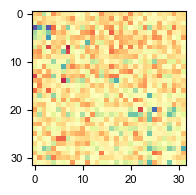

/Users/maryncarlson/nitmb/resample_and_reorder/notebooks/../code/plot_functions.py:147: RuntimeWarning: divide by zero encountered in log10
  s=(-np.log10 (Emat[x,y])))


In [38]:
Epos_mochi, Etot_mochi = compute_enrichment (metaMochi, alpha=best_alphas_mochi[-1])
plot_enrichment_fos (Epos_mochi, np.nanmean (Res, axis=2), Df, metaMochi,
                     outdir=outdir, outlabel='dm_no_null_', save=save)

plt.rcParams["figure.figsize"] = (3,2)

plt.scatter (Df, Etot_mochi, c=avgSign, cmap='Spectral', vmin=-1, vmax=1,
             edgecolor='black', linewidth=0.01)
plt.colorbar (shrink=0.75, label=r'Avg. sign ($\hat D_{ij}$)')
plt.xticks (np.arange (0, np.nanmax (Df),5), np.array (np.arange (0, np.nanmax (Df),5), dtype=int))
plt.axvline (5, color='black', linestyle='--', linewidth=1)
plt.ylabel (r'Enrichment $p$-value')
plt.xlabel ('Physical distance ($\AA$)')

if save :
    plt.savefig ( os.path.join (outdir, 'mochi_distance_' + protein + '.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()   

In [39]:
y_rank = np.zeros_like (y_sing)
lig_rank = np.zeros_like (l_sing)
for i in range (nreps) :
    y_rank[:,i] = compute_mean_ranks (y_sing[:,i])
    lig_rank[:,i] = compute_mean_ranks (l_sing[:,i])

In [40]:
Dmean = np.nanmean (Dsyms, axis=2)
Rmean = np.nanmean (Rmats, axis=2)
Ymean = np.nanmean (y_rank, axis=1)
RLmean = np.nanmean (LRmats, axis=1)
Lmean  = np.nanmean (lig_rank, axis=1)
print (Rmean.shape)

identity = np.linspace (0, np.nanmax (Ymean), 20)
identity_lig = np.linspace (0, np.nanmax (Lmean), 20)

start = 1

(672, 672)


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/1462109225.py:1: RuntimeWarning: Mean of empty slice
  Dmean = np.nanmean (Dsyms, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/1462109225.py:2: RuntimeWarning: Mean of empty slice
  Rmean = np.nanmean (Rmats, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/1462109225.py:3: RuntimeWarning: Mean of empty slice
  Ymean = np.nanmean (y_rank, axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/1462109225.py:4: RuntimeWarning: Mean of empty slice
  RLmean = np.nanmean (LRmats, axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/1462109225.py:5: RuntimeWarning: Mean of empty slice
  Lmean  = np.nanmean (lig_rank, axis=1)


In [41]:
# spectral color map
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-1, 1)

Davg = np.nanmean (Dsyms, axis=2)
Davg[metaP > alpha_geom] = np.nan

avgSign = compute_avg_sign_matrix (Davg)
aadict = make_aa_dict (stop='*')
aas = [key for key in aadict.keys ()]

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/1731374413.py:5: RuntimeWarning: Mean of empty slice
  Davg = np.nanmean (Dsyms, axis=2)


(3, 3)


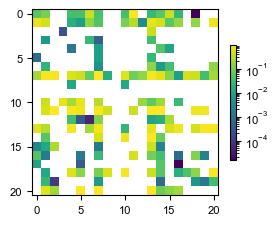

(7, 7)


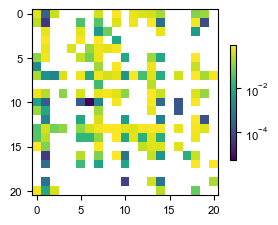

(14, 14)


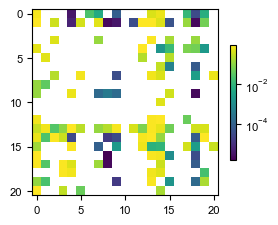

In [42]:
# Focal pairs and their AA's (pdz == Jun)
focal_pairs = [(3,3), (7,7), (14,14)]#,(6,7)]
focal_aas   = [19, 10, 0]#, 16]
pdz_aas     = [19, 1, 9]#, 7]

# focal mutations
focaldict = dict ()

focaldict['pairs']     = focal_pairs #[(3,3), (7,7), (14,14)]
focaldict['pdz_aas']   = focal_aas   #[19, 10, 0]
focaldict['cript_aas'] = pdz_aas     #[19, 1, 9]

# plot p-values
plt.rcParams["figure.figsize"] = (3,3)

for i in range (len (focal_pairs)) :
    j_i, f_i = focal_pairs[i]
    print ((j_i, f_i))
    
    plt.imshow ( metaP[j_i*nAA:(j_i*nAA + nAA),:][:,f_i*nAA:(f_i*nAA + nAA)],
                 norm=mpl.colors.LogNorm ())
    plt.colorbar (shrink=.5)
    plt.show ()

In [43]:
plt.rcParams["figure.figsize"] = (3.5*.95,3.)

# spectral color map
maxval = 1
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-1, 1)

fig, axs = plt.subplots (3, 3, height_ratios=[.65,2,2],
                         sharex='row', sharey='row', constrained_layout=True)

maxval = np.nanmax (np.abs (Dsyms))
bins   = np.linspace (-maxval, maxval, 20)

count = 0
focal_pairs = cp.deepcopy (focaldict['pairs'])
focal_aas   = cp.deepcopy (focaldict['cript_aas'])
pdz_aas     = cp.deepcopy (focaldict['pdz_aas'])

Dmean = np.nanmean (Dsyms, axis=2)
Dsign = np.nanmean (Dsyms, axis=2)
Dsign[Dmean < 0] = -1
Dsign[Dmean > 0] = 1
Dsign[metaP > alpha_geom] = np.nan

avgSign = np.zeros ((npos, npos))
for i in range (npos) :
    for j in range (npos) :
        avgSign[i,j] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])

ct = 0
for pair in focaldict['pairs'] :
    j_i, f_i = cp.deepcopy (pair)
    aalig_i     = focaldict['pdz_aas'][ct]   # pdz aa
    aa_i  = focaldict['cript_aas'][ct] # ligand aa

    # (1) Plot D values
    axs[0,count].hist ( np.ndarray.flatten (Dmean[j_i*nAA:(j_i*nAA + nAA),:][:,f_i*nAA:(f_i*nAA + nAA)]),
                      bins=bins, color=spec( norm (avgSign[j_i,f_i])),
                      edgecolor='black', linewidth=.2)
    
    axs[0,count].axvline (0, color='gray', linestyle='dashed', linewidth=.2)                
    axs[0,count].tick_params(axis='both', which='major', labelsize=6)
    mylabel = r'$\bar D_{i(k),j(\ell)}$'

    axs[0,count].set_title (all_wt[f_i] + str (f_i+1) + ', ' + all_wt[j_i + npos] + str (j_i+1), fontsize=8)
    axs[0,count].set_xlabel (mylabel, labelpad=0, fontsize=8)

    if count == 0 :
        axs[0,count].set_ylabel (r'Count', labelpad=0)
        axs[0,count].set_yticks (np.arange (0,101,50),
                               np.array (np.arange (0,101,50), dtype=int))
    # axis parameters
    axs[0,count].locator_params (axis='x', nbins=5)
    axs[0,count].tick_params (length=2)
    axs[0,count].xaxis.set_tick_params (pad=2)
    axs[0,count].yaxis.set_tick_params (pad=1.5)

    count += 1
    ct += 1
    
    
# PART 2
# spectral color map
maxval = 1
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-1, 1)
maxval = np.nanmax (np.abs (Dsyms))
bins   = np.linspace (-maxval, maxval, 20)

count = 0
focal_pairs = cp.deepcopy (focaldict['pairs'])
focal_aas   = cp.deepcopy (focaldict['cript_aas'])
pdz_aas     = cp.deepcopy (focaldict['pdz_aas'])

# meta p-value and compute average single ranks
y_rank = np.zeros_like (y_sing)
for i in range (nreps) :
    y_rank[:,i] = compute_mean_ranks (y_sing[:,i])

lig_rank = np.zeros_like (l_sing)
for i in range (nreps) :
    lig_rank[:,i] = compute_mean_ranks (l_sing[:,i])

Dmean  = np.nanmean (Dsyms, axis=2)
Rmean  = np.nanmean (Rmats, axis=2)
RLmean = np.nanmean (LRmats, axis=2)
Ymean  = np.nanmean (y_rank, axis=1)
Lmean  = np.nanmean (lig_rank, axis=1)

identity     = np.linspace (0, np.nanmax (Ymean), 20)
identity_lig = np.linspace (0, np.nanmax (Lmean), 20)

Davg = np.nanmean (Dsyms, axis=2)
Dsign = cp.deepcopy (Davg)
Dsign[Davg < 0] = -1
Dsign[Davg > 0] = 1
Dsign[metaP > alpha_geom] = np.nan

avgSign = np.zeros ((npos, npos))
for i in range (npos) :
    for j in range (npos) :
        avgSign[i,j] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])

ct = 0
for pair in focaldict['pairs'] :
    j_i, f_i = cp.deepcopy (pair)
    aalig_i     = focaldict['pdz_aas'][ct]   # pdz aa
    aa_i  = focaldict['cript_aas'][ct] # ligand aa

     # (2) Plot ligand ranks
    gray = axs[1,count].scatter (Lmean, RLmean[f_i*nAA + aa_i,:], c=metaP[:,f_i*nAA + aa_i], cmap='gray',
                                 norm=mpl.colors.LogNorm (vmin=np.nanmin (metaP), vmax=1),
                                 alpha=1., edgecolor='black', linewidth=.1, s=5)
    
    pink = axs[1,count].scatter (Lmean[j_i*nAA:(j_i*nAA + nAA)],
                               RLmean[f_i*nAA + aa_i, j_i*nAA:(j_i*nAA + nAA)],
                               edgecolor=spec( norm (avgSign[f_i,j_i])),
                               cmap='gray', c=metaP[j_i*nAA:(j_i*nAA + nAA),f_i*nAA + aa_i],
                               norm=mpl.colors.LogNorm (vmin=np.nanmin (metaP), vmax=1),
                               alpha=1., linewidth=.3, s=10)
 
    # add annotations for the focal site
    for j in range (nAA) :
        if ~np.isnan (metaP[j_i*nAA + j,f_i*nAA + aa_i]) :
            axs[1,count].annotate ( aas[j], (Lmean[j_i*nAA + j]+5, RLmean[f_i*nAA + aa_i, j_i*nAA + j]+5),
                                   fontsize=6, color='black', zorder=1)#color=spec( norm (avgsign)))

            ymin_j = np.nanmin ([RLmean[ f_i*nAA + aa_i, j_i*nAA + j], Lmean[j_i*nAA + j]])
            ymax_j = np.nanmax ([RLmean[ f_i*nAA + aa_i, j_i*nAA + j], Lmean[j_i*nAA + j]])
            vals   = np.linspace (ymin_j, ymax_j, 10)

            axs[1,count].plot ( np.repeat (Lmean[j_i*nAA + j], 10), vals, linestyle='dashed',
                              color=spec( norm (avgSign[j_i,f_i])), linewidth=.3)


    axs[1,count].plot ( identity_lig, identity_lig, linewidth=.5, linestyle='--', color='black')
   
    # axis labels
    axs[1,count].set_xlabel (r'Jun $\bar R_{i(\ell)}$', labelpad=.5, fontsize=8)
    axs[1,count].locator_params(axis='x', nbins=5)
    axs[1,count].tick_params (length=2)
    axs[1,count].xaxis.set_tick_params (pad=2)
    axs[1,count].yaxis.set_tick_params (pad=1.5)
    
    axs[1,count].set_xticks ( np.arange (0,np.nanmax (Lmean)+1,200),
                              np.array (np.arange (0,np.nanmax (Lmean)+1,200), dtype=int),
                              rotation=0, fontsize=6)
    axs[1,count].set_yticks ( np.arange (0,np.nanmax (Lmean)+1,200),
                              np.array (np.arange (0,np.nanmax (Lmean)+1,200), dtype=int),
                              fontsize=6)


    axs[1,count].annotate (str (f_i + start) + '(' + aas[aa_i] + ')', (475,20), fontsize=6)

    if count == 0 :
        axs[1,count].set_ylabel (r'$\bar R_{j(k),i(\ell)}$', labelpad=0)

    ct += 1
    count += 1
    

# spectral color map
maxval = 1
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-1, 1)
maxval = np.nanmax (np.abs (Dsyms))
bins   = np.linspace (-maxval, maxval, 20)

count = 0
focal_pairs = cp.deepcopy (focaldict['pairs'])
focal_aas   = cp.deepcopy (focaldict['cript_aas'])
pdz_aas     = cp.deepcopy (focaldict['pdz_aas'])

# meta p-value and compute average single ranks
y_rank = np.zeros_like (y_sing)
for i in range (nreps) :
    y_rank[:,i] = compute_mean_ranks (y_sing[:,i])

lig_rank = np.zeros_like (l_sing)
for i in range (nreps) :
    lig_rank[:,i] = compute_mean_ranks (l_sing[:,i])

Dmean  = np.nanmean (Dsyms, axis=2)
Rmean  = np.nanmean (Rmats, axis=2)
RLmean = np.nanmean (LRmats, axis=2)
Ymean  = np.nanmean (y_rank, axis=1)
Lmean  = np.nanmean (lig_rank, axis=1)

identity     = np.linspace (0, np.nanmax (Ymean), 20)
identity_lig = np.linspace (0, np.nanmax (Lmean), 20)

Davg = np.nanmean (Dsyms, axis=2)
Dsign = cp.deepcopy (Davg)
Dsign[Davg < 0] = -1
Dsign[Davg > 0] = 1
Dsign[metaP > alpha_geom] = np.nan

avgSign = np.zeros ((npos, npos))
for i in range (npos) :
    for j in range (npos) :
        avgSign[i,j] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])

ct = 0
for pair in focaldict['pairs'] :
    j_i, f_i = cp.deepcopy (pair)
    aa_i    = focaldict['pdz_aas'][ct]   # pdz aa
    aalig_i = focaldict['cript_aas'][ct] # ligand aa

     # (2) Plot ligand ranks
    gray = axs[2,count].scatter (Ymean, Rmean[f_i*nAA + aa_i,:], c=metaP[f_i*nAA + aa_i,:], cmap='gray',
                                 norm=mpl.colors.LogNorm (vmin=np.nanmin (metaP), vmax=1),
                                 alpha=1., edgecolor='black', linewidth=.1, s=5)
    
    pink = axs[2,count].scatter (Ymean[j_i*nAA:(j_i*nAA + nAA)],
                               Rmean[f_i*nAA + aa_i, j_i*nAA:(j_i*nAA + nAA)],
                               edgecolor=spec( norm (avgSign[f_i,j_i])),
                               cmap='gray', c=metaP[f_i*nAA + aa_i,j_i*nAA:(j_i*nAA + nAA),],
                               norm=mpl.colors.LogNorm (vmin=np.nanmin (metaP), vmax=1),
                               alpha=1., linewidth=.3, s=10)
 
    # add annotations for the focal site
    for j in range (nAA) :
        if ~np.isnan (metaP[j_i*nAA + j,f_i*nAA + aa_i]) :
            axs[2,count].annotate ( aas[j], (Ymean[j_i*nAA + j]+5, Rmean[f_i*nAA + aa_i, j_i*nAA + j]+5),
                                   fontsize=6, color='black', zorder=1)#color=spec( norm (avgsign)))

            ymin_j = np.nanmin ([Rmean[ f_i*nAA + aa_i, j_i*nAA + j], Ymean[j_i*nAA + j]])
            ymax_j = np.nanmax ([Rmean[ f_i*nAA + aa_i, j_i*nAA + j], Ymean[j_i*nAA + j]])
            vals   = np.linspace (ymin_j, ymax_j, 10)

            axs[2,count].plot ( np.repeat (Ymean[j_i*nAA + j], 10), vals, linestyle='dashed',
                              color=spec( norm (avgSign[j_i,f_i])), linewidth=.3)


    axs[2,count].plot ( identity_lig, identity_lig, linewidth=.5, linestyle='--', color='black')
   
    # axis labels
    axs[2,count].set_xlabel (r'Fos $\bar R_{j(\ell)}$', labelpad=.5, fontsize=8)
    axs[2,count].locator_params(axis='x', nbins=5)
    axs[2,count].tick_params (length=2)
    axs[2,count].xaxis.set_tick_params (pad=2)
    axs[2,count].yaxis.set_tick_params (pad=1.5)
    
    axs[2,count].set_xticks ( np.arange (0,np.nanmax (Lmean)+1,200),
                              np.array (np.arange (0,np.nanmax (Lmean)+1,200), dtype=int),
                              rotation=0, fontsize=6)
    axs[2,count].set_yticks ( np.arange (0,np.nanmax (Lmean)+1,200),
                              np.array (np.arange (0,np.nanmax (Lmean)+1,200), dtype=int),
                              fontsize=6)


    axs[2,count].annotate (str (f_i + start) + '(' + aas[aa_i] + ')', (475,20), fontsize=6)

    if count == 0 :
        axs[2,count].set_ylabel (r'$\bar R_{i(k),j(\ell)}$', labelpad=0)

    ct += 1
    count += 1
        
if save :
    plt.savefig ( os.path.join (outdir, 'fig4_e_all.svg'),
                  bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/3923201341.py:19: RuntimeWarning: Mean of empty slice
  Dmean = np.nanmean (Dsyms, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/3923201341.py:20: RuntimeWarning: Mean of empty slice
  Dsign = np.nanmean (Dsyms, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/3923201341.py:84: RuntimeWarning: Mean of empty slice
  Dmean  = np.nanmean (Dsyms, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/3923201341.py:85: RuntimeWarning: Mean of empty slice
  Rmean  = np.nanmean (Rmats, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/3923201341.py:86: RuntimeWarning: Mean of empty slice
  RLmean = np.nanmean (LRmats, axis=2)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/3923201341.py:87: RuntimeWarning: Mean of empty slice
  Ymean  = np.nanmean (y_rank, axis=1)
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/

In [44]:
# just need colorbar from this!
plt.rcParams["figure.figsize"] = (1.5,1.5)

fig, ax = plt.subplots ()
gray = ax.scatter (Lmean, RLmean[f_i*nAA + aa_i,:], c=metaP[:,f_i*nAA + aa_i], cmap='gray',
                             norm=mpl.colors.LogNorm (vmin=np.nanmin (metaP), vmax=1),
                             alpha=1., edgecolor='black', linewidth=.1, s=5)
cbar = fig.colorbar (gray, ax=ax, shrink=0.5, aspect=13)
cbar.set_label ( r'meta $p$-value, $\tilde p_{ij}$', labelpad=6, size=6)
cbar.set_ticks (np.logspace (-6, 0, 3))
cbar.ax.tick_params (labelsize=6, length=3, pad=1)

if save :
    plt.savefig ( os.path.join (outdir, 'fig4_e_colorbar.svg'),
                  bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [45]:
#  D to phen changes
avg_wt  = 10**np.nanmean (np.log10 (y_wt))
yd_mean = 10**np.nanmean (np.log10 (ydoub), axis=2)

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/2630273509.py:3: RuntimeWarning: Mean of empty slice
  yd_mean = 10**np.nanmean (np.log10 (ydoub), axis=2)


In [46]:
for i in range (len (focal_pairs)) :
    print (focal_pairs[i])
    j_i, f_i = focal_pairs[i]
    for j in range (nreps) :
        P_i = cp.deepcopy (Pvals[:,:,j][j_i*nAA:(j_i*nAA+nAA),:][:,f_i*nAA:(f_i*nAA+nAA)])
        D_i = cp.deepcopy (Dsyms[:,:,j][j_i*nAA:(j_i*nAA+nAA),:][:,f_i*nAA:(f_i*nAA+nAA)])
        Y_i = cp.deepcopy (ydoub[:,:,j][j_i*nAA:(j_i*nAA+nAA),:][:,f_i*nAA:(f_i*nAA+nAA)])
        fos_i = cp.deepcopy (y_sing[f_i*nAA:(f_i*nAA + nAA),j])
        jun_i = cp.deepcopy (l_sing[f_i*nAA:(f_i*nAA + nAA),j])

        ntests = np.sum (P_i < alpha_geom)
        npos   = np.sum (np.logical_and (P_i < alpha_geom, D_i > 0)) 
        nneg   = np.sum (np.logical_and (P_i < alpha_geom, D_i < 0))
        nfit   = np.sum (np.logical_and (P_i < alpha_geom, Y_i > y_wt[j]))

        print ('Total significant: ' + str (ntests))
        print ('Total positive: ' + str (npos))
        print ('Total negative: ' + str (nneg))
        print (npos / ntests)
        print ('Fitness > wt: ' + str (nfit))
        print ('Fos > wt: ' + str (np.sum (fos_i > y_wt[j])))
        print ('Jun > wt: ' + str (np.sum (jun_i > y_wt[j])))

        print ()

(3, 3)
Total significant: 34
Total positive: 34
Total negative: 0
1.0
Fitness > wt: 0
Fos > wt: 0
Jun > wt: 1

Total significant: 38
Total positive: 38
Total negative: 0
1.0
Fitness > wt: 0
Fos > wt: 0
Jun > wt: 1

Total significant: 27
Total positive: 27
Total negative: 0
1.0
Fitness > wt: 0
Fos > wt: 0
Jun > wt: 1

(7, 7)
Total significant: 32
Total positive: 2
Total negative: 30
0.0625
Fitness > wt: 0
Fos > wt: 13
Jun > wt: 1

Total significant: 44
Total positive: 3
Total negative: 41
0.06818181818181818
Fitness > wt: 1
Fos > wt: 14
Jun > wt: 1

Total significant: 37
Total positive: 2
Total negative: 35
0.05405405405405406
Fitness > wt: 0
Fos > wt: 14
Jun > wt: 1

(14, 14)
Total significant: 38
Total positive: 27
Total negative: 11
0.7105263157894737
Fitness > wt: 13
Fos > wt: 3
Jun > wt: 3

Total significant: 41
Total positive: 32
Total negative: 9
0.7804878048780488
Fitness > wt: 13
Fos > wt: 3
Jun > wt: 3

Total significant: 45
Total positive: 32
Total negative: 13
0.711111111111

In [47]:
#focal_pairs = [(3,3), (7,7), (7,6),(6,7)]
plt.rcParams["figure.figsize"] = (2,2)
maxval = np.nanmax (np.abs (Dmean))

for i in focal_pairs :
    l2 = i[1]
    l1 = i[0]
    print ((l1, l2))
    
    fig, ax = plt.subplots ()

    daa = ax.imshow (Dmean[l1*nAA:(l1*nAA + nAA),:][:,l2*nAA:(l2*nAA + nAA)], vmin=-maxval, vmax=maxval,
                     cmap='Spectral')
    cbar = fig.colorbar (daa, ax=ax, shrink=0.75)
    cbar.set_label ( r'$\bar D_{ij}$', labelpad=-6)

    # R&R
    x, y = np.where (metaP[l1*nAA:(l1*nAA + nAA),:][:,l2*nAA:(l2*nAA + nAA)] <= alpha_geom)

    for i in range (len (x)) :
        ax.add_patch( Rectangle((y[i]-.5, x[i]-.5), 1, 1, fill=False,lw=.5))# label=r'$\leq 5\AA$')
    
    metacp = cp.deepcopy (metaP[l1*nAA:(l1*nAA + nAA),:][:,l2*nAA:(l2*nAA + nAA)])
    Dcp    = cp.deepcopy (Dmean[l1*nAA:(l1*nAA + nAA),:][:,l2*nAA:(l2*nAA + nAA)])

    ax.set_xticks (np.arange (0,nAA,1), aas, fontsize=6)
    ax.set_yticks (np.arange (0,nAA,1), aas, fontsize=6)
    ax.set_ylabel ('Jun position ' + all_wt[npos + l2] + str (l2+1))
    ax.set_xlabel ('Fos position ' + all_wt[l1] + str (l1+1))
    ax.tick_params (length=2)
    ax.xaxis.set_tick_params (pad=2)
    ax.yaxis.set_tick_params (pad=1.5)

    if save :
        plt.savefig ( os.path.join (outdir, str (l2+1) + '_' + str (l1+1) + '.pdf'),
                     bbox_inches='tight', dpi=600, transparent=True)
        plt.close ()
    else :
        plt.show ()
        
   

(3, 3)
(7, 7)
(14, 14)


In [48]:
for i in range (nreps) :
    print (i)
    print (scipy.stats.spearmanr ( y_sing[:,i], np.nanmean (ydoub[:,:,i], axis=0),
                                   nan_policy='omit'))
    for j in range (i+1,nreps) :
        print (scipy.stats.spearmanr ( np.ndarray.flatten (ydoub[:,:,i]),
                                       np.ndarray.flatten (ydoub[:,:,j]),
                                       nan_policy='omit'))

0
SignificanceResult(statistic=0.9873559411313555, pvalue=0.0)


/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4111/3701145582.py:3: RuntimeWarning: Mean of empty slice
  print (scipy.stats.spearmanr ( y_sing[:,i], np.nanmean (ydoub[:,:,i], axis=0),


SignificanceResult(statistic=0.9303876329818502, pvalue=0.0)
SignificanceResult(statistic=0.9302889179609198, pvalue=0.0)
1
SignificanceResult(statistic=0.9896338132268596, pvalue=0.0)
SignificanceResult(statistic=0.9306108754021355, pvalue=0.0)
2
SignificanceResult(statistic=0.9904879906397634, pvalue=0.0)


In [49]:
##END

In [50]:
mochi_thresholds

array([0.00361875, 0.00238989, 0.00300939])

In [51]:
two_thresholds

array([0.04827071, 0.04827071, 0.04827071])